# Wstęp
Zadanie 12 jest trzecią częścią do zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2. Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3. Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem trzeciego etapu prac jest ewaluacja modelu MultiBTC sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji. 

# Warunki zaliczenia

Do zaliczenia trzeciego etapu należy wytrenować modelu oraz wykonać ewaluację predykcji dla scenariusza godzinnego oraz dziennego, z uwzględnieniem wpływu:
 * wybranych hiperparametrów 
 * dodatkowych kroków wstępnego przetwarzania danych
 * wymiarów afektywnych


# Realizacja zadania

Szczegółowa realizacja zadania powinna uwzględniać następujące elementy ewaluacji:

### Hiperparametry (4 pkt.)

W zadaniu tym istnieje szereg ustawień hiperparametrów, które mogą mieć istotny wpływ na jakość predykcji. Należy wybrać jeden z nich i zbadać jego wpływ dla 3 wybranych wartości. 

1. Długość sekwencji w modelu LSTM.
2. Liczba jednostek w warstwie ukrytej. 
3. Optymalizator i jego parametry (np. `learning rate`).
4. Użycie dodatkowej warstwy Dropout (parametr: `probability`) przed warstwą z wynikiem predykcji.

### Przetwarzanie wstępne (3 pkt.)

Jednocześnie istotny wpływ mogą mieć dodatkowe elementy przetwarzania wstępnego danych. Należy wybrać jeden z nich i porównać z wariantem bez przetwarzania:
1. Normalizacja wartości (sprowadzenie konkretnych kwot do wartości z zakresu 0-1).
2. Zamiana wartości liczbowej na procentową zmianę względem poprzedniego kursu.

### Wymiary afektywne  (3 pkt.)

Ostatnim aspektem jest zbadanie wpływu wymiarów afektywnych. Dla najlepszej otrzymanej konfiguracji należy porównać wyniki z modelem, który wykorzystuje wyłącznie dane z giełdy.

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:
1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

df_1h = pd.read_csv('df_1h.csv')
df_24h = pd.read_csv('df_24h.csv')

device = 'cuda'

# Mod model

In [114]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, -1] 
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def fit(model, criterion, optimizer, num_epochs, train_loader, val_loader, patience = 20):
  train_losses = []
  val_losses = []
  train_r2 = []
  val_r2 = []
  best_loss = np.inf
  counter = 0
  for epoch in tqdm(range(num_epochs)):
      true_values = []
      train_predictions = []
      val_predictions = []


      model.train()
      train_loss = 0.0
      for inputs, targets in train_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets.unsqueeze(1))
          loss.backward()
          optimizer.step()
          train_predictions.extend(outputs.cpu().detach().numpy())
          true_values.extend(targets.cpu().detach().numpy())
          
          train_loss += loss.item()

      train_r2.append(r2_score(true_values, train_predictions))

      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, targets.unsqueeze(1))

              val_predictions.extend(outputs.cpu().detach().numpy())
              true_values.extend(targets.cpu().detach().numpy())

              val_loss += loss.item()
          early_loss = val_loss/len(val_loader)
          val_r2.append(r2_score(true_values[len(train_predictions):], val_predictions))
      train_losses.append(train_loss/len(train_loader)) 
      val_losses.append(val_loss/len(val_loader))
      if early_loss < best_loss:
        best_loss = early_loss
        counter = 0
      else:
        counter += 1
        if counter > patience:
          break


  n = len(train_losses)
  xs = np.arange(1, 1+n)

  return best_loss, xs, train_losses, val_losses, train_r2, val_r2

def MultiBTC(seq_length = 10, target_name = 'close', df = df_24h, num_epochs = 10, hidden_dim = 64, learning_rate = .001, scaler = MinMaxScaler()):
  df_dates =df.copy()
  df = df.copy()
  df.drop(columns = 'date', inplace=True)
  
  cols = list(df.columns)
  cols.remove(target_name)
  df = df[cols + [target_name]]
  if scaler is not None:
    scaled_df = scaler.fit_transform(df)
  else:
    scaled_df = df.to_numpy()
  sequences, targets = create_sequences(scaled_df, seq_length)     

  train_size = int(len(sequences) * 0.8)
  val_size = int(len(sequences) * 0.1)


  train_sequences = sequences[:train_size]
  train_targets = targets[:train_size]
  val_sequences = sequences[train_size:train_size + val_size]
  val_targets = targets[train_size:train_size + val_size]
  test_sequences = sequences[train_size + val_size:]
  test_targets = targets[train_size + val_size:]


  train_dataset = TimeSeriesDataset(train_sequences, train_targets)
  val_dataset = TimeSeriesDataset(val_sequences, val_targets)
  test_dataset = TimeSeriesDataset(test_sequences, test_targets)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  input_dim = train_sequences.shape[2]
  num_layers = 2
  output_dim = 1

  model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  return model,  *fit(model, criterion, optimizer, num_epochs, train_loader, val_loader), test_loader, scaler, df, df_dates

def plot_results(model, best_loss, xs, train_losses, val_losses, train_r2, val_r2, test_loader, scaler, df, df_dates, printit=True):
  if printit:

    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (25,10))

    ax1.plot(xs, train_losses,label = 'train loss')
    ax1.plot(xs, val_losses,label = 'val loss')
    ax1.set_title("MSE Error for epoch")
    ax1.legend()

    ax2.plot(xs, train_r2,label = 'train r2')
    ax2.plot(xs, val_r2, label = 'val r2')
    ax2.set_title("R2 Error for epoch")
    ax2.legend()  


  model.eval()
  predictions = []
  true_values = []

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          predictions.append(outputs.cpu().numpy())
          true_values.append(targets.cpu().numpy())

  predictions = np.concatenate(predictions)
  true_values = np.concatenate(true_values)
  if scaler is not None:
    predictions = scaler.inverse_transform(np.concatenate([np.zeros((predictions.shape[0], df.shape[1]-1)), predictions], axis=1))[:, -1]
    true_values = scaler.inverse_transform(np.concatenate([np.zeros((true_values.shape[0], df.shape[1]-1)), true_values.reshape(-1, 1)], axis=1))[:, -1]
  else:
    predictions = np.concatenate([np.zeros((predictions.shape[0], df.shape[1]-1)), predictions], axis=1)[:, -1]
    true_values = np.concatenate([np.zeros((true_values.shape[0], df.shape[1]-1)), true_values.reshape(-1, 1)], axis=1)[:, -1]
  print(f"Best loss: {best_loss}")
  dates = df_dates[len(df_dates) - len(true_values): ]['date']
  return pd.DataFrame({'date': dates, 'True BTC': true_values, 'Predicted BTC': predictions})

def make_model(btc_df, day_model = False, min_idx = None, max_idx = None):
  if day_model:
    real_df = btc_df[btc_df['date'].dt.time == pd.to_datetime('23:00:00').time()][['date','True BTC']]
    pred_df = btc_df.groupby('date').mean().reset_index()[['date', 'Predicted BTC']]
    btc_df = real_df.merge(pred_df, how = 'left', on = 'date')
  df = btc_df.copy()
  predictions = df['Predicted BTC']
  true_values = df['True BTC']
  n= len(predictions)
  xs = np.arange(n)
  fig, ax = plt.subplots()
  ax.plot(xs[min_idx:max_idx], true_values[min_idx:max_idx], label = 'real')
  ax.plot(xs[min_idx:max_idx], predictions[min_idx:max_idx], label = 'predictions')
  ax.legend()
  print(f'RMSE: {np.sqrt(mean_squared_error(true_values, predictions))}')
  display(df)

# Zad 1

In [44]:
params = {"seq_length": [5,10,15],"hidden_dim": [8,16,32,64], "learning_rate": [0.001, 0.01, 0.1]}

## sequence

100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Best loss: 1.7545737950003417e-05
RMSE: 105.99118175485994


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8925.306947
19008,2020-03-03 01:00:00,8828.270134,8902.374230
19009,2020-03-03 02:00:00,8879.760086,8867.508149
19010,2020-03-03 03:00:00,8880.010186,8865.411324
19011,2020-03-03 04:00:00,8842.279863,8863.663135
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9435.822848
21115,2020-05-29 20:00:00,9421.340059,9433.057978
21116,2020-05-29 21:00:00,9394.860025,9429.627570
21117,2020-05-29 22:00:00,9427.440141,9418.981444


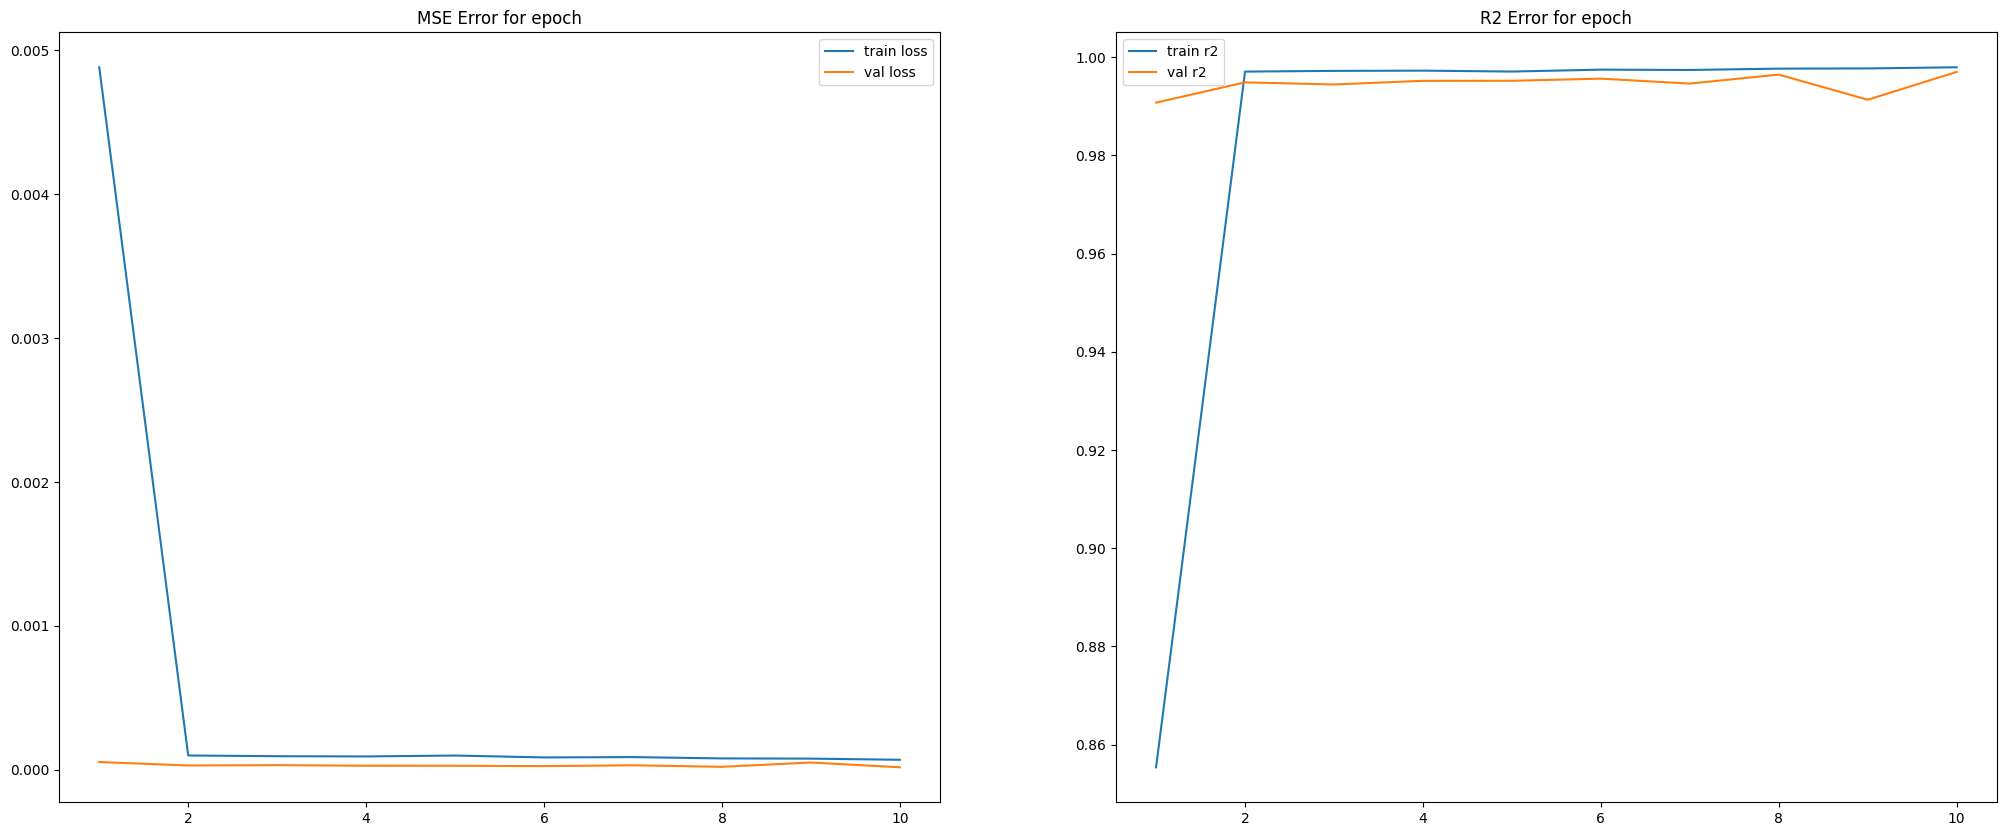

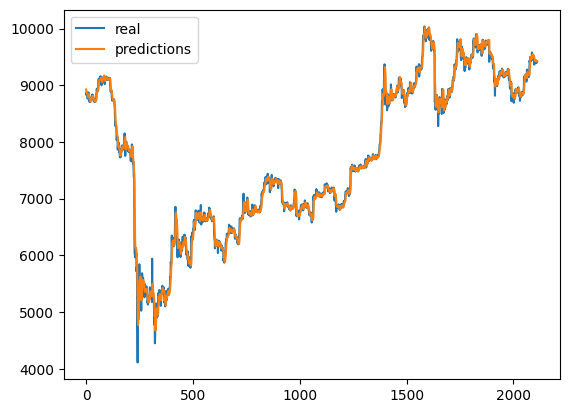

In [45]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=5))
make_model(btc_df)

100%|██████████| 10/10 [01:14<00:00,  7.43s/it]


Best loss: 1.640634316531346e-05
RMSE: 155.26268476656062


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,9059.663653
19008,2020-03-03 01:00:00,8828.270134,9013.895085
19009,2020-03-03 02:00:00,8879.760086,8957.523814
19010,2020-03-03 03:00:00,8880.010186,8985.200901
19011,2020-03-03 04:00:00,8842.279863,8997.217352
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9561.613970
21115,2020-05-29 20:00:00,9421.340059,9552.895153
21116,2020-05-29 21:00:00,9394.860025,9545.010557
21117,2020-05-29 22:00:00,9427.440141,9528.562465


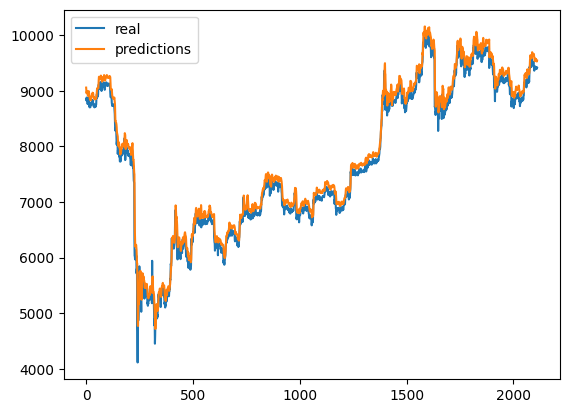

In [46]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=10), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:49<00:00,  4.94s/it]

Best loss: 1.9847264421845136e-05
RMSE: 118.47549843198168


,date,True BTC,Predicted BTC
19006,2020-03-02 23:00:00,8917.340098,8851.913901
19007,2020-03-03 00:00:00,8848.379945,8869.811233
19008,2020-03-03 01:00:00,8828.270134,8839.619376
19009,2020-03-03 02:00:00,8879.760086,8806.977048
19010,2020-03-03 03:00:00,8880.010186,8801.566305
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9364.693220
21115,2020-05-29 20:00:00,9421.340059,9366.354146
21116,2020-05-29 21:00:00,9394.860025,9359.660339
21117,2020-05-29 22:00:00,9427.440141,9347.119473


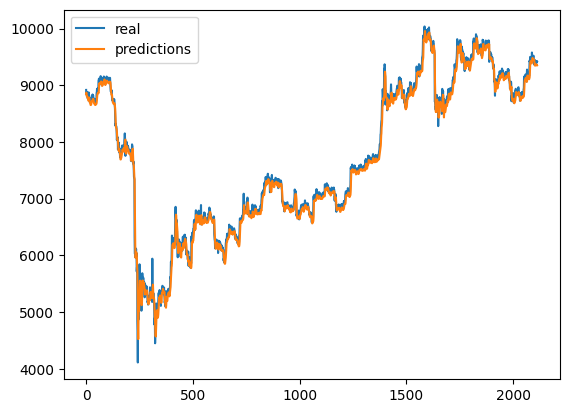

In [47]:
btc_df = plot_results(*MultiBTC(df = df_1h, seq_length=3), printit=False)
make_model(btc_df)

## hidden

100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

Best loss: 2.0842609752903765e-05
RMSE: 114.45475920784047


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8908.156156
19008,2020-03-03 01:00:00,8828.270134,8893.671279
19009,2020-03-03 02:00:00,8879.760086,8875.004444
19010,2020-03-03 03:00:00,8880.010186,8868.070141
19011,2020-03-03 04:00:00,8842.279863,8860.359237
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9415.356467
21115,2020-05-29 20:00:00,9421.340059,9411.763223
21116,2020-05-29 21:00:00,9394.860025,9407.106952
21117,2020-05-29 22:00:00,9427.440141,9405.705729


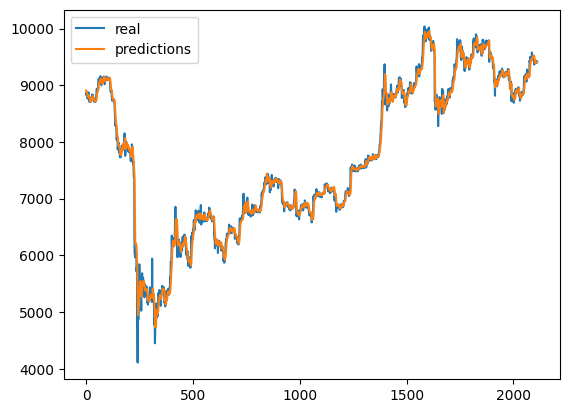

In [48]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=8), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:14<00:00,  1.40s/it]

Best loss: 2.3672578279412406e-05
RMSE: 119.03610826198167


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8959.171797
19008,2020-03-03 01:00:00,8828.270134,8947.310665
19009,2020-03-03 02:00:00,8879.760086,8918.866998
19010,2020-03-03 03:00:00,8880.010186,8912.063799
19011,2020-03-03 04:00:00,8842.279863,8906.017161
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9461.436094
21115,2020-05-29 20:00:00,9421.340059,9462.090778
21116,2020-05-29 21:00:00,9394.860025,9458.262882
21117,2020-05-29 22:00:00,9427.440141,9451.916459


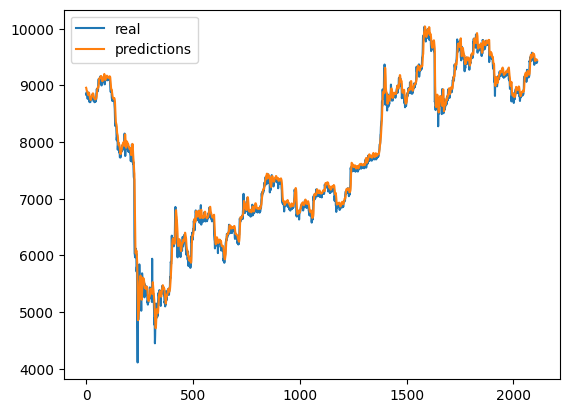

In [49]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=16), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

Best loss: 1.819808995557623e-05
RMSE: 107.09307097040568


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8894.951420
19008,2020-03-03 01:00:00,8828.270134,8865.025528
19009,2020-03-03 02:00:00,8879.760086,8828.077653
19010,2020-03-03 03:00:00,8880.010186,8825.980829
19011,2020-03-03 04:00:00,8842.279863,8835.767264
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9390.713138
21115,2020-05-29 20:00:00,9421.340059,9385.544979
21116,2020-05-29 21:00:00,9394.860025,9378.097117
21117,2020-05-29 22:00:00,9427.440141,9373.784472


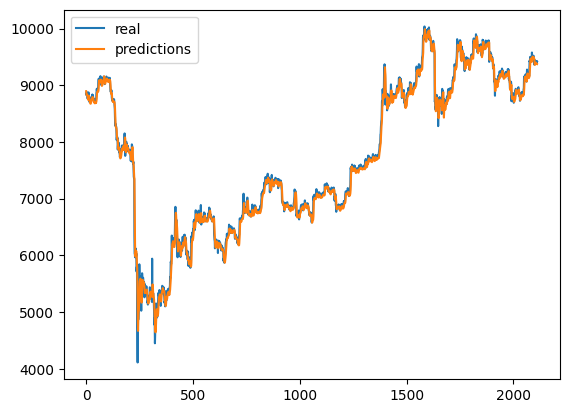

In [50]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=32), printit=False)
make_model(btc_df)

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

Best loss: 1.8394565055738592e-05
RMSE: 165.39115571306442


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8734.704229
19008,2020-03-03 01:00:00,8828.270134,8688.825434
19009,2020-03-03 02:00:00,8879.760086,8658.795995
19010,2020-03-03 03:00:00,8880.010186,8681.284045
19011,2020-03-03 04:00:00,8842.279863,8702.810947
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9231.217498
21115,2020-05-29 20:00:00,9421.340059,9214.796128
21116,2020-05-29 21:00:00,9394.860025,9219.963452
21117,2020-05-29 22:00:00,9427.440141,9201.772599


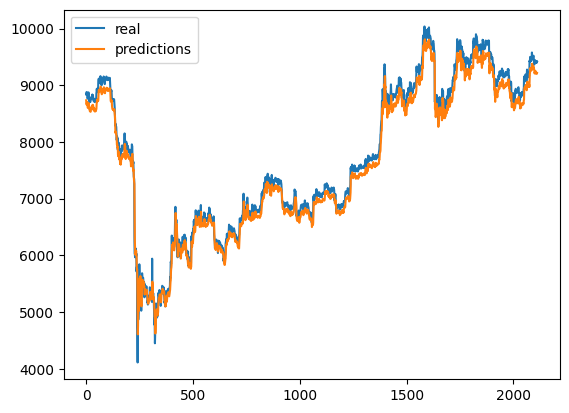

In [51]:
btc_df = plot_results(*MultiBTC(df = df_1h, hidden_dim=64), printit=False)
make_model(btc_df)

## learning rate

100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

Best loss: 0.00012375223361066838
RMSE: 165.16317304161407


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,9092.250032
19008,2020-03-03 01:00:00,8828.270134,9033.230800
19009,2020-03-03 02:00:00,8879.760086,8982.804291
19010,2020-03-03 03:00:00,8880.010186,8974.738488
19011,2020-03-03 04:00:00,8842.279863,9029.043830
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9576.041227
21115,2020-05-29 20:00:00,9421.340059,9554.804090
21116,2020-05-29 21:00:00,9394.860025,9554.865049
21117,2020-05-29 22:00:00,9427.440141,9541.737974


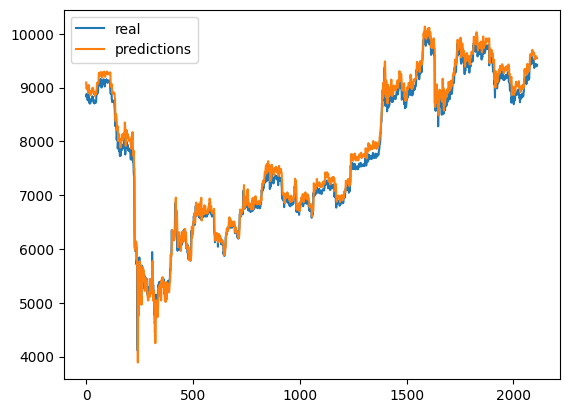

In [52]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.1), printit=False)
make_model(btc_df)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

Best loss: 1.406674491453018e-05
RMSE: 159.51778812091064


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8780.034811
19008,2020-03-03 01:00:00,8828.270134,8718.456550
19009,2020-03-03 02:00:00,8879.760086,8784.272301
19010,2020-03-03 03:00:00,8880.010186,8695.440327
19011,2020-03-03 04:00:00,8842.279863,8745.610474
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9281.912060
21115,2020-05-29 20:00:00,9421.340059,9270.549039
21116,2020-05-29 21:00:00,9394.860025,9273.378208
21117,2020-05-29 22:00:00,9427.440141,9259.265349


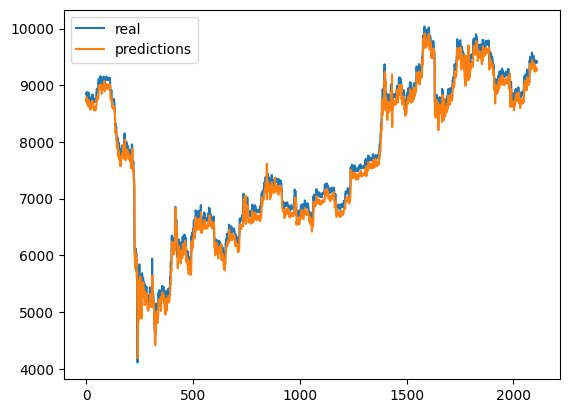

In [53]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.01), printit=False)
make_model(btc_df)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

Best loss: 2.622744725820005e-05
RMSE: 110.9979037514105


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8981.135849
19008,2020-03-03 01:00:00,8828.270134,8945.621765
19009,2020-03-03 02:00:00,8879.760086,8904.203837
19010,2020-03-03 03:00:00,8880.010186,8904.765830
19011,2020-03-03 04:00:00,8842.279863,8916.170185
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9486.878989
21115,2020-05-29 20:00:00,9421.340059,9479.588118
21116,2020-05-29 21:00:00,9394.860025,9468.823414
21117,2020-05-29 22:00:00,9427.440141,9458.448682


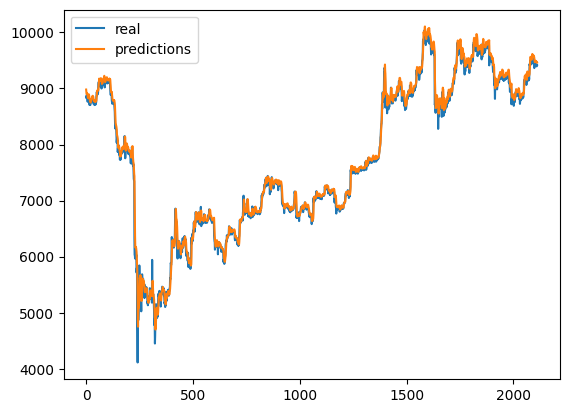

In [54]:
btc_df = plot_results(*MultiBTC(df = df_1h, learning_rate=.001), printit=False)
make_model(btc_df)

# Zad 2

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]

Best loss: 1.947600647630073e-05
RMSE: 115.73577964023266


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8848.764906
19008,2020-03-03 01:00:00,8828.270134,8809.371153
19009,2020-03-03 02:00:00,8879.760086,8768.094767
19010,2020-03-03 03:00:00,8880.010186,8781.712020
19011,2020-03-03 04:00:00,8842.279863,8804.238483
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9340.299155
21115,2020-05-29 20:00:00,9421.340059,9331.445060
21116,2020-05-29 21:00:00,9394.860025,9326.827201
21117,2020-05-29 22:00:00,9427.440141,9323.272369


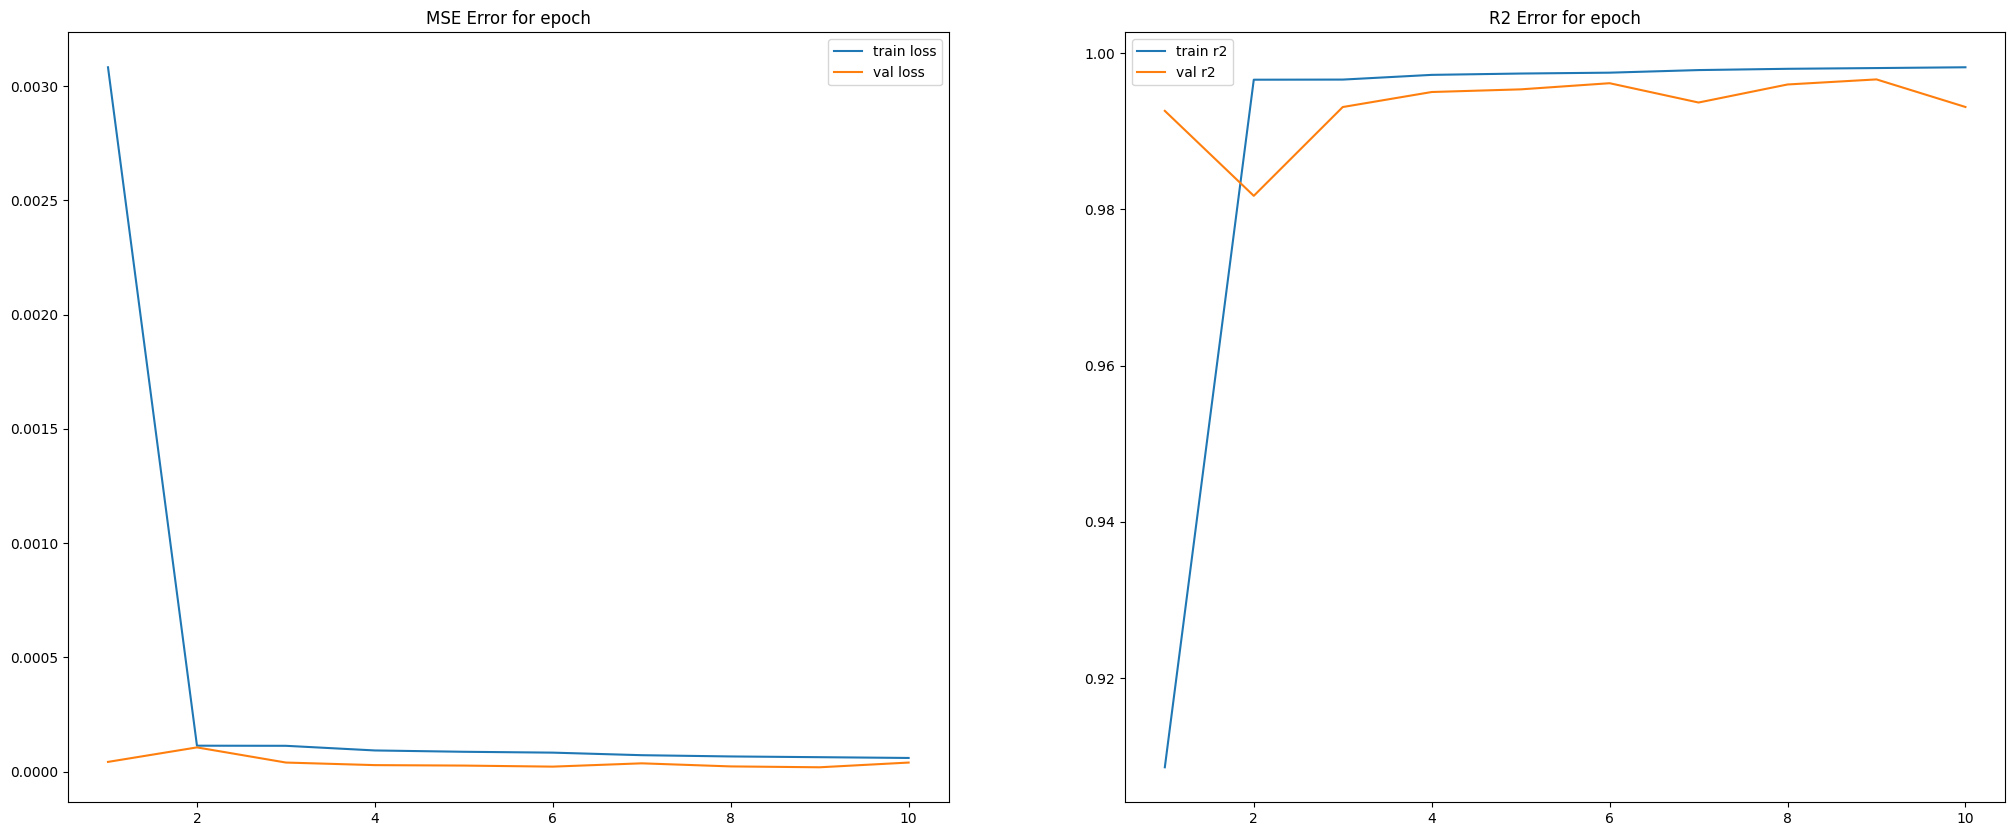

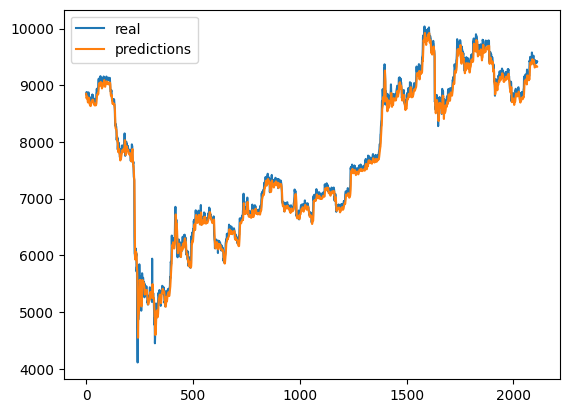

In [64]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = MinMaxScaler()), printit=True)
make_model(btc_df)

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

Best loss: 66689536.06060606
RMSE: 7503.886085026704


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379883,347.231689
19008,2020-03-03 01:00:00,8828.269531,347.231689
19009,2020-03-03 02:00:00,8879.759766,347.231689
19010,2020-03-03 03:00:00,8880.009766,347.231689
19011,2020-03-03 04:00:00,8842.280273,347.231689
...,...,...,...
21114,2020-05-29 19:00:00,9403.990234,347.231689
21115,2020-05-29 20:00:00,9421.339844,347.231689
21116,2020-05-29 21:00:00,9394.860352,347.231689
21117,2020-05-29 22:00:00,9427.440430,347.231689


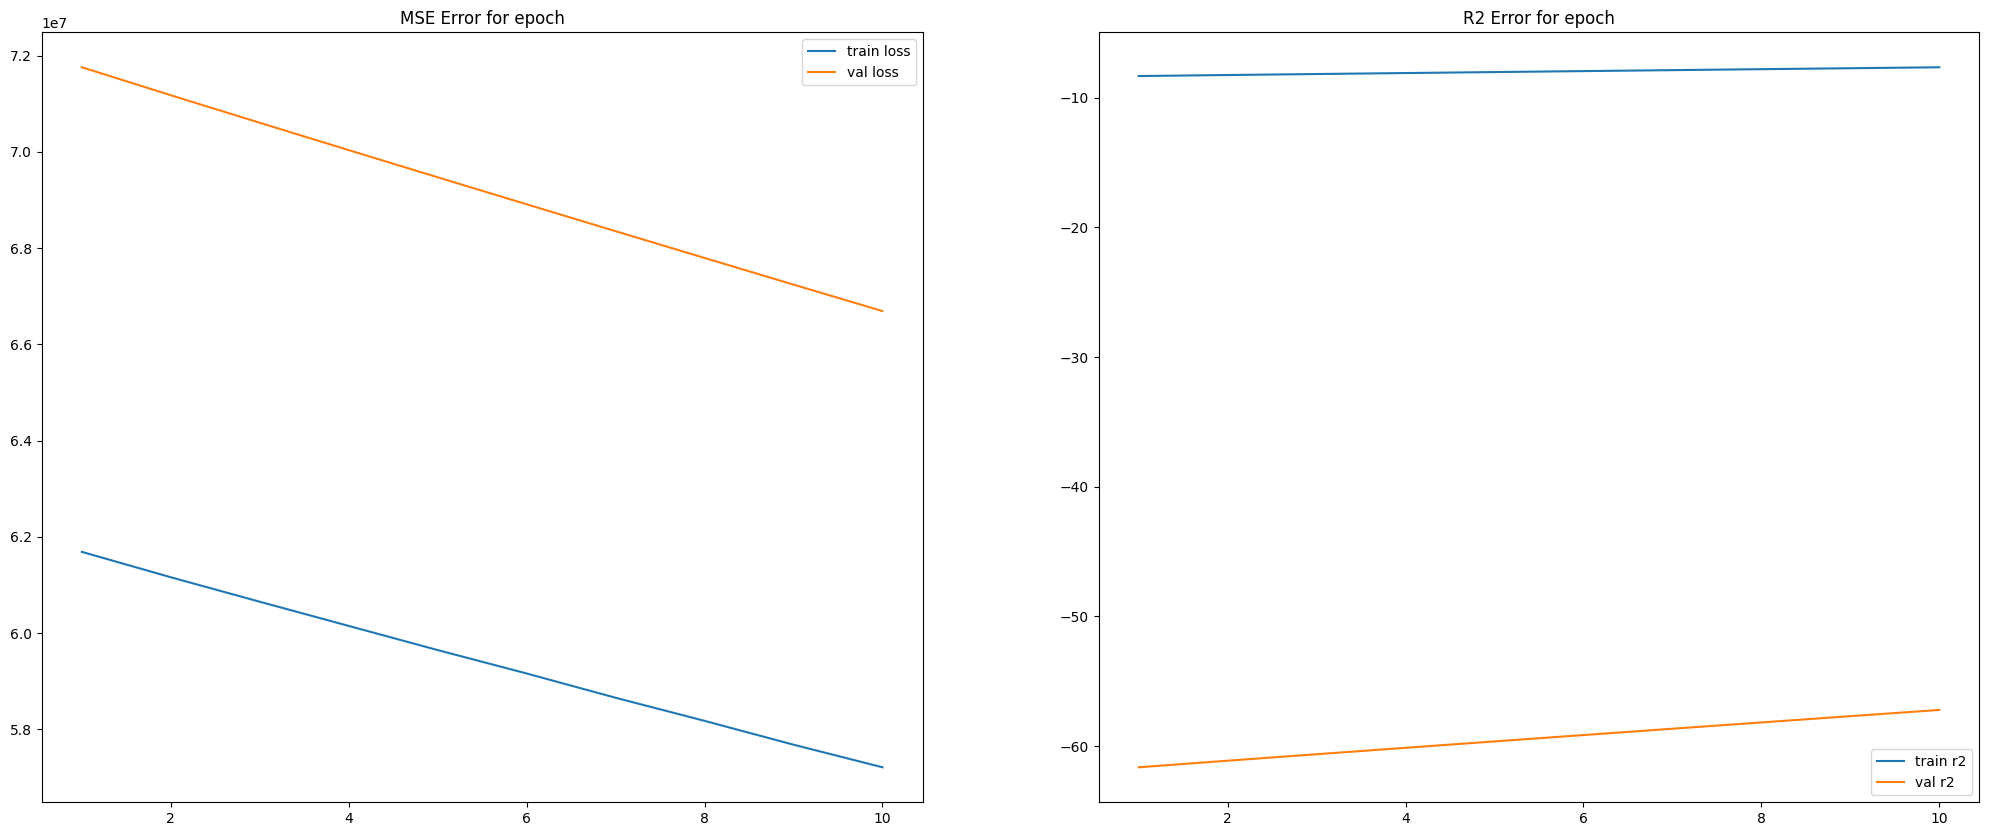

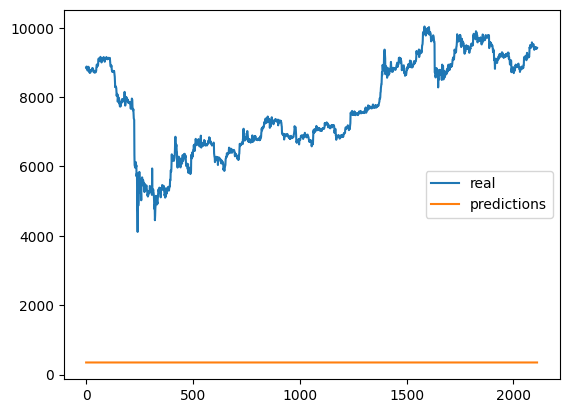

In [63]:
btc_df = plot_results(*MultiBTC(df = df_1h, scaler = None, num_epochs=100), printit=True)
make_model(btc_df)

# Zad 3

In [76]:
stock_cols = ["date", "open", "high", "low"	,"close", "volume"]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]

Best loss: 1.435328589526431e-05
RMSE: 117.25949349537885


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8824.290258
19008,2020-03-03 01:00:00,8828.270134,8787.331945
19009,2020-03-03 02:00:00,8879.760086,8756.613168
19010,2020-03-03 03:00:00,8880.010186,8759.864040
19011,2020-03-03 04:00:00,8842.279863,8778.345076
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9317.384809
21115,2020-05-29 20:00:00,9421.340059,9306.775426
21116,2020-05-29 21:00:00,9394.860025,9301.220636
21117,2020-05-29 22:00:00,9427.440141,9291.961120


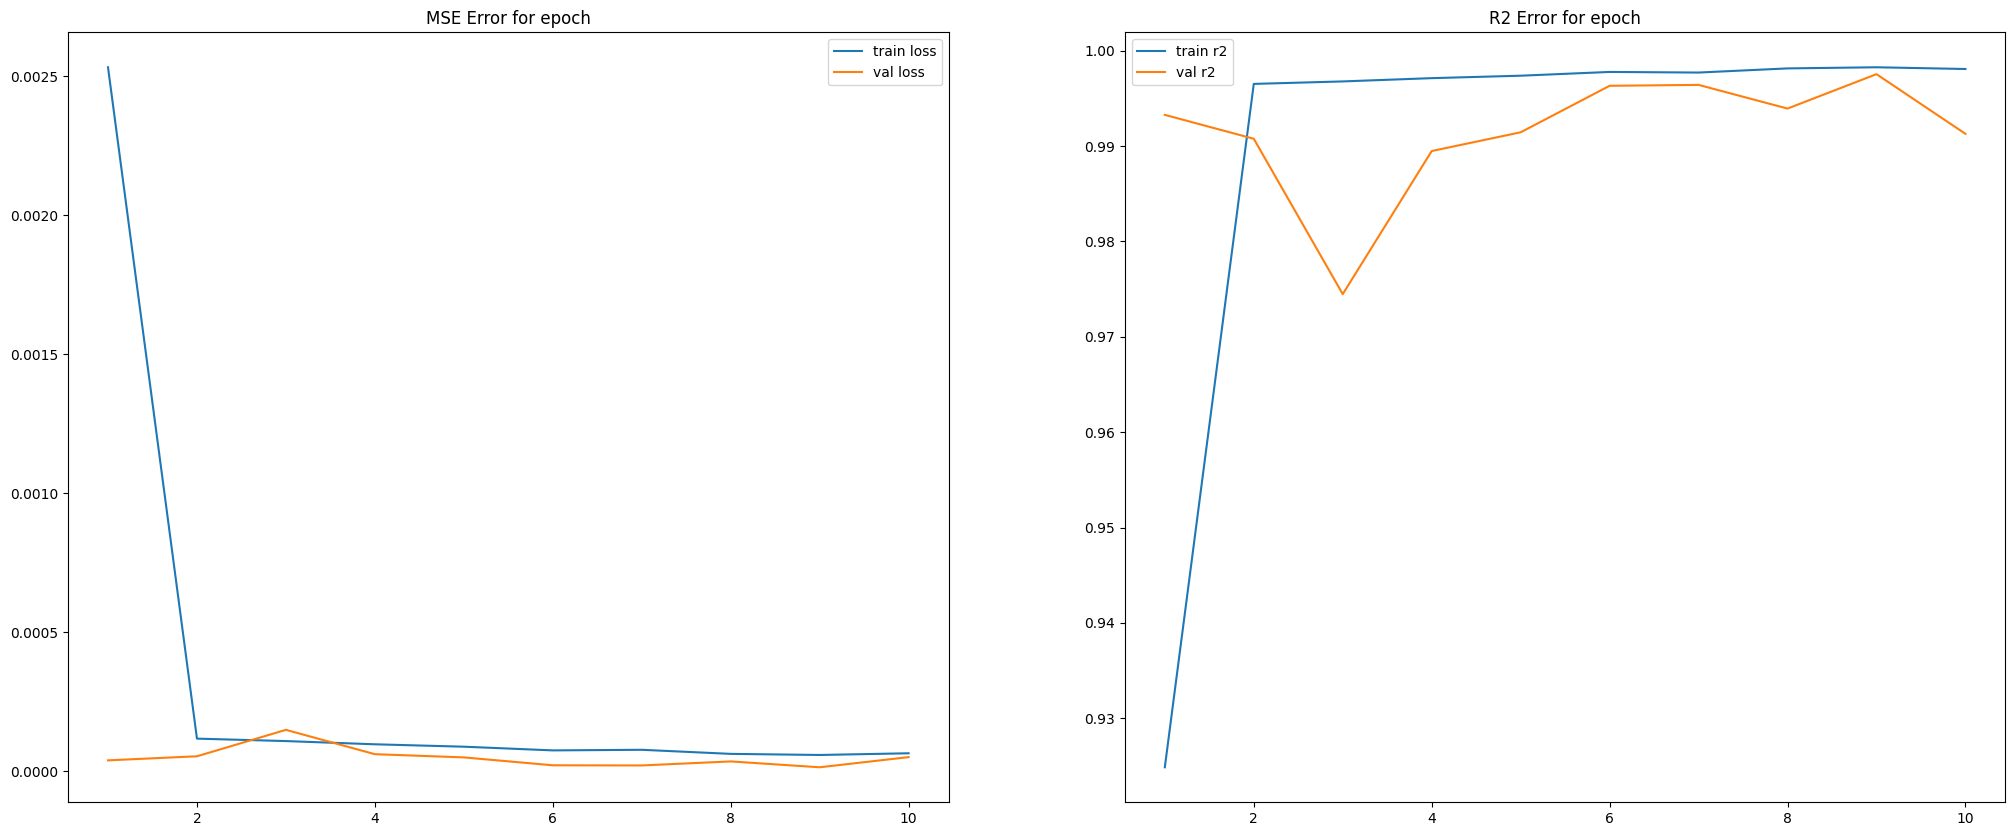

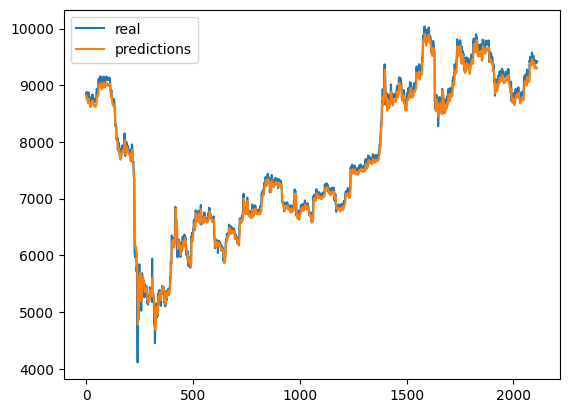

In [77]:
btc_df = plot_results(*MultiBTC(df = df_1h[stock_cols]), printit=True)
make_model(btc_df)

In [84]:
import itertools
def all_subsets(lst):
    subsets = []
    for i in range(len(lst) + 1):
        for subset in itertools.combinations(lst, i):
            subsets.append(list(subset))
    return subsets

cols = list(df_1h.columns)
cols.remove('date')
cols.remove('close')
all_cols_subsets = all_subsets(cols)

In [96]:
dict_to_plot = {}
#model, best_loss, xs, train_losses, val_losses, train_r2, val_r2, test_loader, scaler, df, df_dates 
for cols_subset in all_cols_subsets:
    key = ['date', 'close'] + cols_subset
    results = MultiBTC(df = df_1h[key])
    dict_to_plot[str(key)] = results

  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: 

['date', 'close', 'low']
Best loss: 1.464561392016218e-05


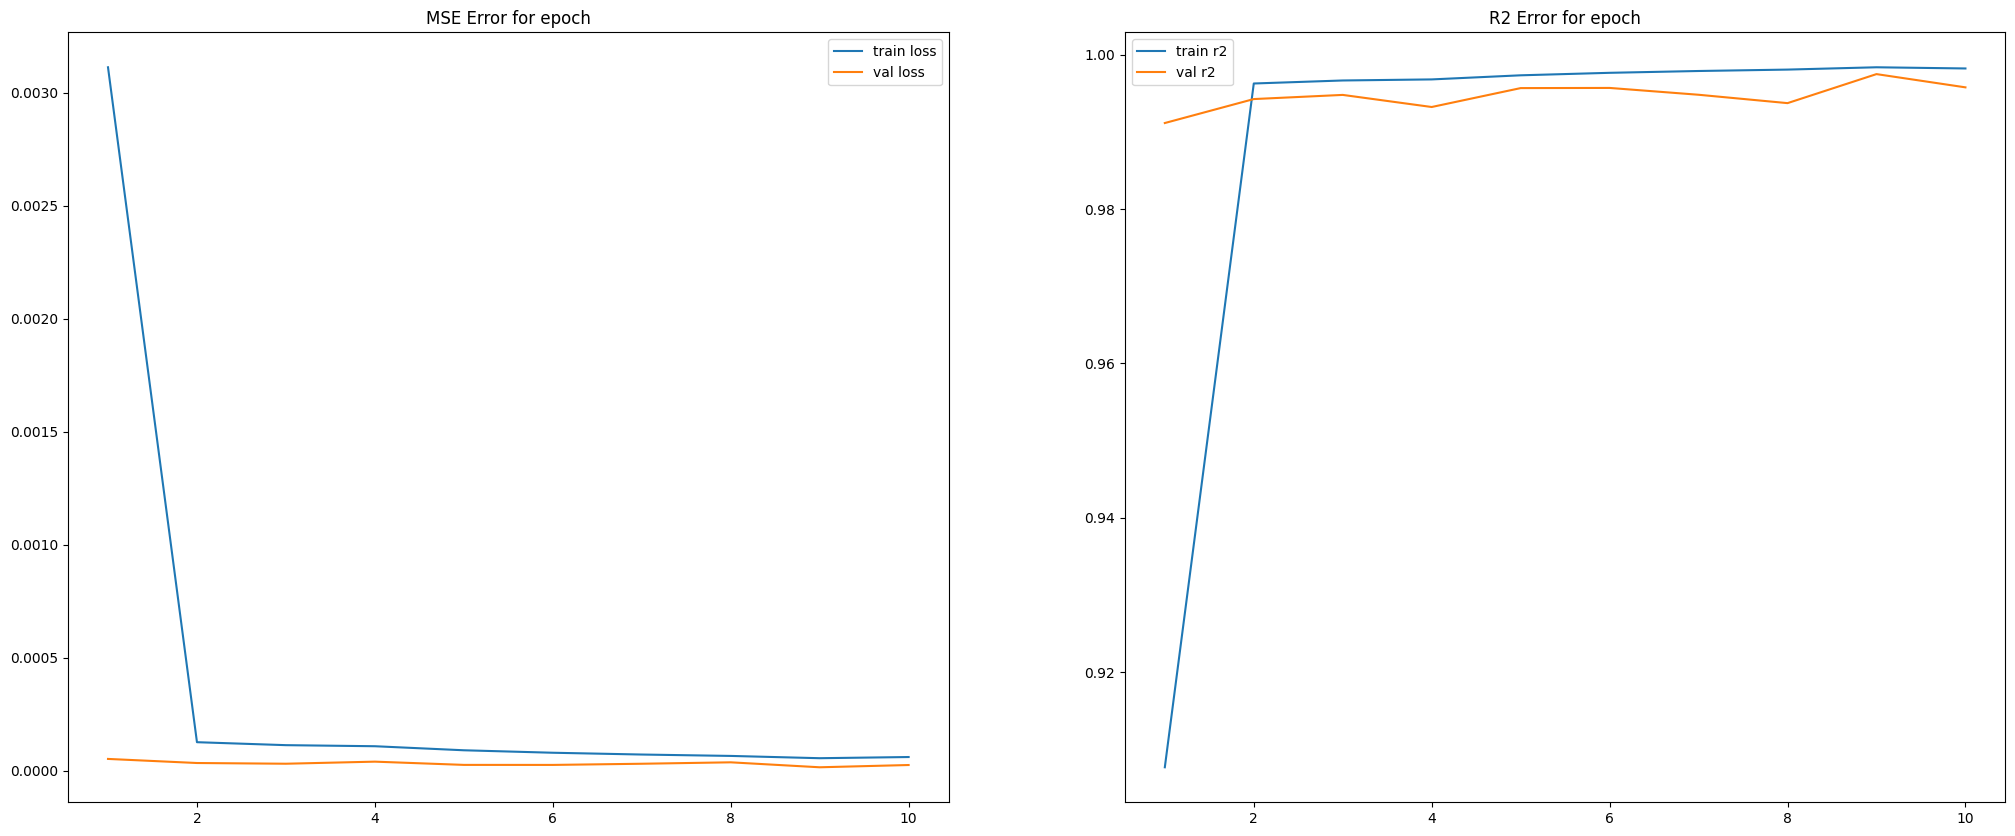

In [115]:
key = min(dict_to_plot, key= lambda k: dict_to_plot[k][1])
print(key)
max_btc = plot_results(*dict_to_plot[key], printit=True)

RMSE: 100.7757520912311


,date,True BTC,Predicted BTC
19007,2020-03-03 00:00:00,8848.379945,8976.563919
19008,2020-03-03 01:00:00,8828.270134,8929.552788
19009,2020-03-03 02:00:00,8879.760086,8903.583391
19010,2020-03-03 03:00:00,8880.010186,8910.942737
19011,2020-03-03 04:00:00,8842.279863,8929.294338
...,...,...,...
21114,2020-05-29 19:00:00,9403.990107,9491.480146
21115,2020-05-29 20:00:00,9421.340059,9480.226518
21116,2020-05-29 21:00:00,9394.860025,9480.044893
21117,2020-05-29 22:00:00,9427.440141,9467.944518


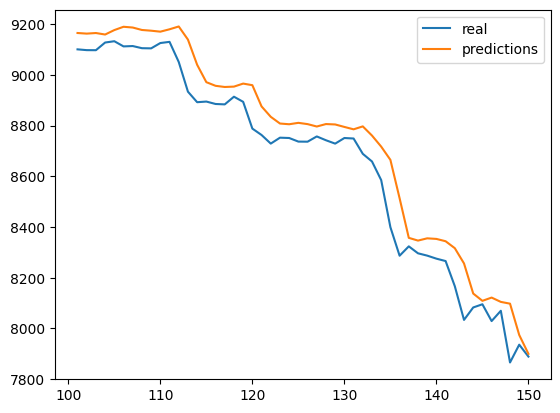

In [118]:
make_model(max_btc, min_idx=101, max_idx=151)